### Envs

In [1]:
# use env: pycircos

import os
import pycircos
import matplotlib as mpl
import matplotlib.pyplot as plt
from Bio import SeqIO, SeqFeature
from BCBio import GFF
import pandas as pd
import numpy as np
import copy

In [8]:
def get_gbk(fgbk, sample_id):
    records = list(SeqIO.parse(fgbk, "genbank"))
    # only return the first record
    record = records[0]
    record.id = sample_id
    record.name = sample_id
    record.features.append(SeqFeature.SeqFeature(SeqFeature.FeatureLocation(0, len(record)), type="source", strand=1))
    return record


def get_cds(record):
    # feature locations store in a list [feature_id, start, end, strand]
    feature_locations = []
    for feature in record.features:
        if feature.type == "CDS":
            feature_locations.append([feature.qualifiers["locus_tag"][0], feature.qualifiers["phrog"][0], feature.location.start.real, feature.location.end.real])

    # convert to dataframe
    df_cds = pd.DataFrame(feature_locations, columns=["feature_id", "phrog", "start", "end"])
    # width of each feature
    df_cds["width"] = df_cds["end"] - df_cds["start"] + 1
    return df_cds


def read_phrog_annot(fin="/Users/allen/data2/db/phrogs/phrog_annot_v4.tsv"):
    df_phrog = pd.read_csv(fin, sep="\t")
    # convert column "phrog" to str
    df_phrog["phrog"] = df_phrog["phrog"].astype(str)
    return df_phrog


def add_phrog_to_cds(df_cds, df_phrog):
    df_cds = df_cds.merge(df_phrog, on="phrog", how="left")
    # fill NaN in column "color" with #222223
    df_cds["color"] = df_cds["color"].fillna("#c9c9c9")
    # fill NaN in column "category" with "Unknown"
    df_cds["category"] = df_cds["category"].fillna("unknown function")
    return df_cds


def plot_circos(sample_id, record, df_cds_anno, tick_max, tick_interval, tick_label_size, window_size=300):
    garc = pycircos.Garc(arc_id=sample_id, record=record, interspace=0, linewidth=0, facecolor="black", raxis_range=(0,0), label=sample_id, label_visible=True)
    gcircle = pycircos.Gcircle(figsize=(8,8))
    gcircle.add_garc(garc)
    gcircle.set_garcs(0, 360)

    # add tickplot
    tlabels = [f"{tl / 1000:.0f} K" for tl in range(0, tick_max, tick_interval)]
    gcircle.tickplot(sample_id, raxis_range=(600,607), tickinterval=tick_interval, tickcolor="#7B7D7D", ticklabels=tlabels, ticklabelsize=tick_label_size, ticklabelorientation="horizontal")
    gcircle.tickplot(sample_id, raxis_range=(600,602), tickinterval=int(tick_interval/10), tickcolor="#7B7D7D")

    # Plot source
    feat_source = []
    for feat in garc.record.features:
        if feat.type == "source":
            feat_source.append(feat)
            a = feat
    # gcircle.featureplot(sample_id, source=feat_source, raxis_range=(510,511), facecolor="#36454F")

    # plot gc skew
    skews = garc.calc_nnskew(n1="G", n2="C", window_size=window_size)  
    positive_skews=copy.deepcopy(skews)
    positive_skews[skews<0]=0
    negative_skews=copy.deepcopy(skews)
    negative_skews[skews>=0]=0
    gcircle.lineplot(sample_id, positive_skews, rlim=(min(skews),max(skews)), raxis_range=(160,300), linecolor="#275ba5")
    gcircle.lineplot(sample_id, negative_skews, rlim=(min(skews),max(skews)), raxis_range=(160,300), linecolor="#560061")

    # plot gc content
    gc_content = garc.calc_nnratio(n1="G", n2="C", window_size=window_size)
    gcircle.lineplot(sample_id, gc_content, rlim=(min(gc_content),max(gc_content)), raxis_range=(300,450), linecolor="#009CDE", linewidth=0.5)
    # gcircle.featureplot(sample_id, source=feat_source, raxis_range=(249,251), facecolor="#C3D7EE")

    #Plot CDS
    feat_CDS_plus  = []
    feat_CDS_minus = []
    for feat in garc.record.features:
        if "CDS" in feat.type:
            if feat.strand == 1:
                feat_CDS_plus.append(feat)
            else:
                feat_CDS_minus.append(feat)
    gcircle.featureplot(sample_id, source=feat_CDS_plus,  raxis_range=(450,480), facecolor="#69B3E7")
    gcircle.featureplot(sample_id, source=feat_CDS_minus, raxis_range=(480,510), facecolor="#C1A7E2")


    # PHROGs
    gcircle.barplot(sample_id, data=[1]*len(df_cds_anno["start"]), positions=df_cds_anno["start"], width=df_cds_anno["width"], raxis_range=(513, 598), facecolor=df_cds_anno["color"])

    return gcircle


def read_rbh_result(rbh_result_file):
    clms = ['QUERY', 'TARGET', 'FIDENT', 'ALNLEN', 'MISMATCH', 'GAPOPEN', 'QSTART', 'QEND', 'TSTART', 'TEND', 'EVALUE', 'BITS']
    df = pd.read_table(rbh_result_file, header=None, names=clms)
    # filter FIDENT>0.2
    df = df[df["FIDENT"]>0.2].copy()
    return df.drop_duplicates(subset="TARGET").sort_values("TARGET")


def parse_rbh(rbh_result_file):
    """parse rbh result"""
    df = read_rbh_result(rbh_result_file)
    contents = []
    for query, ident in zip(df["TARGET"], df["FIDENT"]):
        start, end, strand = str(query).split("|")[1].split("_")
        contents.append([query, start, end, strand, ident])

    df_contents = pd.DataFrame(contents, columns=["query", "start", "end", "strand", "ident"])
    df_contents["widths"] = df_contents.apply(lambda x: int(x["end"]) - int(x["start"]) + 1, axis=1)
    df_contents["positions"] = df_contents["start"].astype(int)
    return df_contents[["ident", "positions", "widths"]].to_dict(orient="list")


def get_rbh_fpath(sample_id, rbhdir):
    return os.path.join(rbhdir, f"{sample_id}_vs_reference_rbh.tsv")

### load data

In [11]:
fgbk = "phageM_NODE_1.gbk"
sample_id = "PhageM"

record = get_gbk(fgbk, sample_id)
df_cds = get_cds(record)
df_phrog = read_phrog_annot()

# add phrog annotations to df_cds
df_cds_anno = add_phrog_to_cds(df_cds, df_phrog)

# get rbh result
# file path MGCplotter generated rbh result
fdir_rbh = "output_mgcplotter/rbh_search"
genomes = ["GCF_000907515.1", "GCF_000908675.1", "GCF_000916495.1", "GCF_000927515.1", "GCF_001470095.1", "GCF_001470235.1", "GCF_001470635.1", "GCF_001500795.2", "GCF_001501195.1", "GCF_001745115.1", "GCF_002615865.1", "GCF_002617965.1", "GCF_002617985.1", "GCF_002623585.1", "GCF_002627085.1", "GCF_002627105.1", "GCF_002627125.1", "GCF_002627145.1", "GCF_002627165.1", "GCF_002955315.1", "GCF_002957285.1", "GCF_003023935.1", "GCF_003613395.1", "GCF_003613955.1", "GCF_004015525.1", "N1", "N2"]
rbhs = {x: parse_rbh(get_rbh_fpath(x, fdir_rbh)) for x in genomes}

GCF_000907515.1
GCF_000908675.1
GCF_000916495.1
GCF_000927515.1
GCF_001470095.1
GCF_001470235.1
GCF_001470635.1
GCF_001500795.2
GCF_001501195.1
GCF_001745115.1
GCF_002615865.1
GCF_002617965.1
GCF_002617985.1
GCF_002623585.1
GCF_002627085.1
GCF_002627105.1
GCF_002627125.1
GCF_002627145.1
GCF_002627165.1
GCF_002955315.1
GCF_002957285.1
GCF_003023935.1
GCF_003613395.1
GCF_003613955.1
GCF_004015525.1
N1
N2


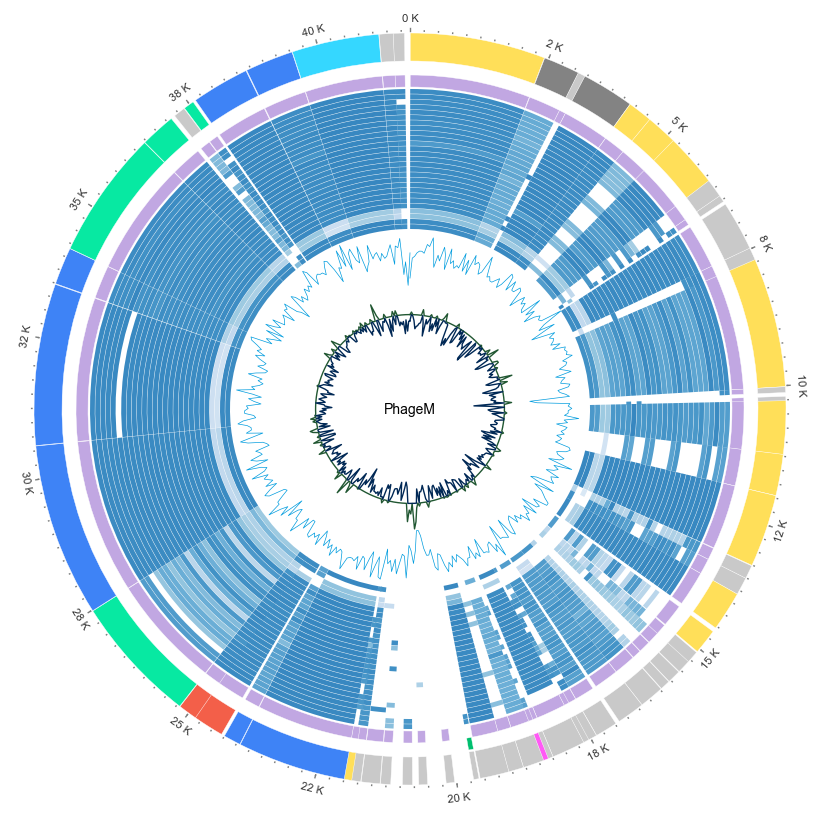

In [47]:
tick_max = 42000
tick_interval = 2500
tick_label_size = 8
window_size = 100

garc = pycircos.Garc(arc_id=sample_id, record=record, interspace=0, linewidth=0, facecolor="black", raxis_range=(0,0), label=sample_id, label_visible=True)
gcircle = pycircos.Gcircle(figsize=(8,8))
gcircle.add_garc(garc)
gcircle.set_garcs(0, 360)

# plot gc skew
skews = garc.calc_nnskew(n1="G", n2="C", window_size=window_size)  
positive_skews=copy.deepcopy(skews)
positive_skews[skews<0]=0
negative_skews=copy.deepcopy(skews)
negative_skews[skews>=0]=0
gcircle.lineplot(sample_id, positive_skews, rlim=(min(skews),max(skews)), raxis_range=(160,300), linecolor="#215732")
gcircle.lineplot(sample_id, negative_skews, rlim=(min(skews),max(skews)), raxis_range=(160,300), linecolor="#002855")


# plot gc content
gc_content = garc.calc_nnratio(n1="G", n2="C", window_size=window_size)
gcircle.lineplot(sample_id, gc_content, rlim=(min(gc_content),max(gc_content)), raxis_range=(300,450), linecolor="#009CDE", linewidth=0.5)
# gcircle.featureplot(sample_id, source=feat_source, raxis_range=(249,251), facecolor="#C3D7EE")

# plot RBH of other genomes
rx_min = 450
for sample in rbhs.keys():
    print(sample)
    rbh = rbhs[sample]
    gcircle.heatmap(sample_id, data=rbh["ident"], positions=rbh["positions"], width=rbh["widths"], raxis_range=(rx_min,rx_min+12), cmap=plt.cm.Blues, vmin=0, vmax=1.5)
    rx_min += 13


#Plot CDS
feat_CDS_plus  = []
feat_CDS_minus = []
for feat in garc.record.features:
    if "CDS" in feat.type:
        if feat.strand == 1:
            feat_CDS_plus.append(feat)
        else:
            feat_CDS_minus.append(feat)
gcircle.featureplot(sample_id, source=feat_CDS_minus, raxis_range=(rx_min+4,rx_min+34), facecolor="#C1A7E2", linewidth=0.3, edgecolor="white")
gcircle.featureplot(sample_id, source=feat_CDS_plus,  raxis_range=(rx_min+34,rx_min+64), facecolor="#00BF6F", linewidth=0.3, edgecolor="white")


# PHROGs
gcircle.barplot(sample_id, data=[1]*len(df_cds_anno["start"]), positions=df_cds_anno["start"], width=df_cds_anno["width"], raxis_range=(rx_min+69, rx_min+139), facecolor=df_cds_anno["color"], linewidth=0.3, edgecolor="white")


# add tickplot
tlabels = [f"{tl / 1000:.0f} K" for tl in range(0, tick_max, tick_interval)]
gcircle.tickplot(sample_id, raxis_range=(rx_min+144,rx_min+151), tickinterval=tick_interval, tickcolor="#7B7D7D", ticklabels=tlabels, ticklabelsize=tick_label_size, ticklabelorientation="horizontal")
gcircle.tickplot(sample_id, raxis_range=(rx_min+144,rx_min+145), tickinterval=int(tick_interval/10), tickcolor="#7B7D7D")

# Plot source
feat_source = []
for feat in garc.record.features:
    if feat.type == "source":
        feat_source.append(feat)
        a = feat
# gcircle.featureplot(sample_id, source=feat_source, raxis_range=(510,511), facecolor="#36454F")



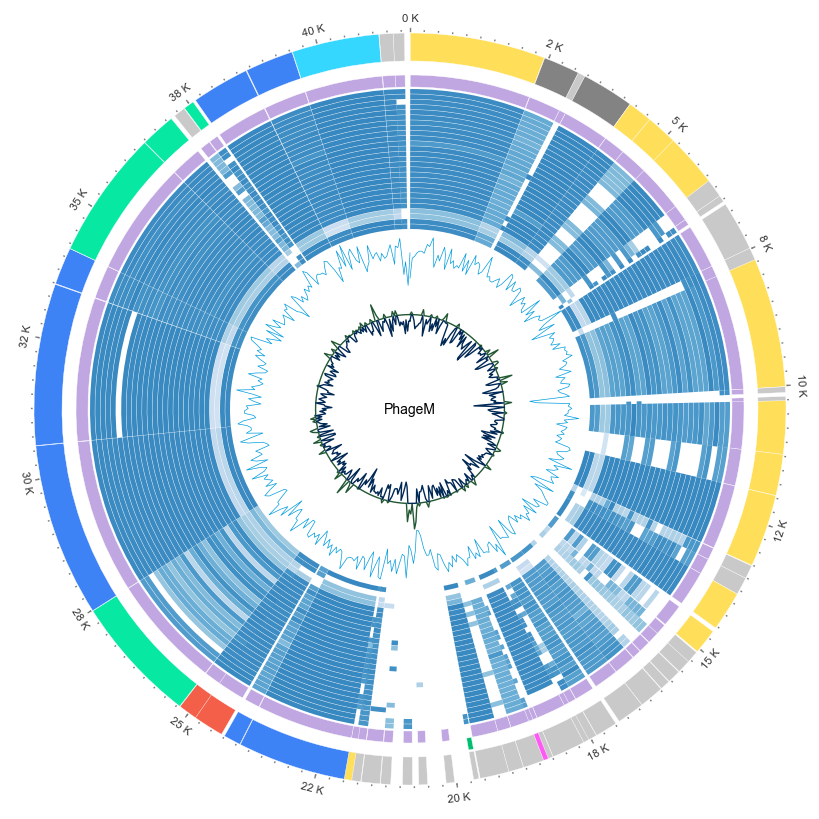

In [48]:
gcircle.save("pangenome_phageM", format="pdf", dpi=300)